In [1]:
import numpy as np
import torch

In [2]:
from sklearn.gaussian_process.kernels import RBF

In [79]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [80]:
import pandas as pd

In [4]:
from tqdm.auto import tqdm

In [55]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.data_binary import generate_data, evaluate_policy, estimate_p_t
from kcmc.experiment_policy_evaluation import log_csv, get_data

In [6]:
import csv
import os.path

### Data

In [7]:
n = 1000
np.random.seed(0)
Y, T, X, U, e_x, e_xu = generate_data(n)
p_t = estimate_p_t(X, T)

In [8]:
beta_e_x = np.asarray([0, 0.75, -0.5, 0, -1])


def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1.0 - T) * e_x + T * (1.0 - e_x)


# def zero_policy(X):
#    return np.zeros(X.shape[0], dtype=int)

### Ground Truth

In [9]:
evaluate_policy(toy_policy, n=1000000)

tensor(3.6258, dtype=torch.float64)

### IPW estimator

In [10]:
est_ipw = ipw(Y, T, X, p_t, toy_policy)

In [11]:
est_ipw

tensor(3.4380, dtype=torch.float64)

### Hajek estimator

In [12]:
est_hajek = hajek(Y, T, X, p_t, toy_policy)

In [13]:
est_hajek

tensor(3.7397, dtype=torch.float64)

### Implement Confounding Robust Inference

In [14]:
est, w = confounding_robust_estimator(
    Y,
    T,
    X,
    p_t,
    toy_policy,
    D=200,
    Gamma=1.5,
    gamma=0.01,
    alpha=0.05,
    hard_kernel_const=False,
    f_divergence="total variation",
    normalize_p_t=True,
    hajek_const=False,
    kernel_const=False,
    quantile_const=True,
    tan_box_const=True,
    lr_box_const=False,
    f_const=False,
    return_w=True,
)

In [15]:
est

tensor(3.3228, dtype=torch.float64)

### Design Neural Dual Model

In [ ]:
torch.

In [25]:
from kcmc.estimators import get_normalized_p_t


def confounding_robust_dual_nn(
    Y,
    T,
    X,
    p_t,
    policy,
    Gamma=1.5,
    gamma=0.01,
    f_divergence="total variation",
    normalize_p_t=True,
    tan_box_const=True,
    lr_box_const=False,
    f_const=False,
    n_iter=200,
    train_policy=False,
    lr_log_eta_f=5e-2,
    lr_eta_nn=5e-2,
    weight_decay_nn=1e-2,
    nn_seed=0,
    return_eta=False,
):
    p_t_original = p_t
    if normalize_p_t:
        p_t = get_normalized_p_t(p_t, T)
    p_t = torch.as_tensor(p_t)
    TX = np.concatenate([T[:, None], X], axis=1)
    TX /= TX.std(axis=0, keepdims=True)
    TX = torch.as_tensor(TX).float()
    f_conj = get_f_conjugate(Gamma, gamma, p_t_original, f_divergence, tan_box_const, lr_box_const, f_const)
    eta_nn, log_eta_f = get_multipliers(seed=nn_seed)  # reparaemtrization log_eta_f makes it non-convex...:p
    params = [
        {"params": log_eta_f, "lr": lr_log_eta_f},
        {"params": eta_nn.parameters(), "lr": lr_eta_nn, "weight_decay": weight_decay_nn},
    ]
    if train_policy:
        params.update({"params": policy.parameters(), "lr": 1e-3})
    optimizer = torch.optim.SGD(params=params)

    def objective():
        pi = policy(X, T)
        r = Y * pi / p_t
        eta_f = torch.exp(log_eta_f)
        eta_nn_TX = eta_nn(TX)[:, 0] * pi / p_t
        return torch.mean(-eta_f * gamma + eta_nn_TX - eta_f * f_conj((eta_nn_TX - r) / eta_f))

    for i in range(n_iter):
        loss = -objective()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return (objective(), log_eta_f, eta_nn) if return_eta else objective()


def get_f_conjugate(Gamma, gamma, p_t, f_divergence, tan_box_const, lr_box_const, f_const):
    if bool(tan_box_const) != bool(lr_box_const):
        if tan_box_const:
            a = p_t * (1 + 1 / Gamma * (1 / p_t - 1))
            b = p_t * (1 + Gamma * (1 / p_t - 1))
        elif lr_box_const:
            a = 1 / Gamma
            b = Gamma
        a, b = map(torch.as_tensor, (a, b))

        def f_conjugate(x):
            return torch.where(x > 0.0, b * x, a * x)

    elif f_const:
        # See
        # - https://arxiv.org/abs/1606.00709
        # - http://www.stat.yale.edu/~yw562/teaching/598/lec06.pdf
        # - https://en.wikipedia.org/wiki/F-divergence
        f, f_conj = {
            "KL": [lambda u: u * torch.log(u), lambda v: torch.exp(v - 1)],
            "inverse KL": [lambda u: -torch.log(u), lambda v: -1 - torch.log(-v)],
            "Jensen-Shannon": [
                lambda u: -(u + 1) * torch.log((1 + u) / 2) + u * torch.log(u),
                lambda v: torch.where(v < torch.log(2.0), -torch.log(2 - torch.exp(v)), torch.inf),
            ],
            "squared Hellinger": [
                lambda u: u - 2 * torch.sqrt(u) + 1,
                lambda v: torch.where(v < 1.0, v / (1 - v), torch.inf),
            ],
            "Pearson chi squared": [lambda u: u**2 - 1, lambda v: v**2 / 4.0 + v],
            "Neyman chi squared": [
                lambda u: 1.0 / u - 1,
                lambda v: torch.where(torch.abs(v) <= 0.0, -2 * torch.sqrt(-v) + 1, torch.inf),
            ],
            "total variation": [
                lambda u: 0.5 * torch.abs(u - 1),
                lambda v: torch.where(torch.abs(v) < 0.5, v, torch.inf),
            ],
        }[f_divergence]
        raise NotImplementedError
    return f_conjugate


def get_multipliers(n_hidden=30, n_layers=3, seed=None):
    torch.manual_seed(seed)
    input_dims = [1 + X.shape[1]] + [n_hidden] * (n_layers - 1)
    output_dims = [n_hidden] * (n_layers - 1) + [1]
    layers = [
        layer
        for (d_in, d_out) in zip(input_dims, output_dims)
        for layer in (torch.nn.Linear(d_in, d_out), torch.nn.ReLU())
    ]
    eta_nn = torch.nn.Sequential(*layers[:-1])
    eta_nn[-1].weight.data.fill_(0.0)
    eta_nn[-1].bias.data.fill_(0.0)
    log_eta_f = torch.tensor(0.0, requires_grad=True)
    return eta_nn, log_eta_f

In [26]:
est, log_eta_f, eta_nn = confounding_robust_dual_nn(
    Y,
    T,
    X,
    p_t,
    toy_policy,
    Gamma=1.5,
    gamma=0.01,
    f_divergence="total variation",
    normalize_p_t=True,
    tan_box_const=True,
    f_const=False,
    n_iter=100,
    weight_decay_nn=0.02,
    train_policy=False,
    return_eta=True,
)

In [27]:
est

tensor(3.3996, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [28]:
kcmc.estimators.f_divergences

['KL',
 'inverse KL',
 'Jensen-Shannon',
 'squared Hellinger',
 'Pearson chi squared',
 'Neyman chi squared',
 'total variation']

### Policy Evaluation Experiments with Dual NN method

In [92]:
EXAMPLE_PARAMS = {
    "Gamma": 1.5,
    "gamma": 0.01,
    "f_divergence": "KL",
    "normalize_p_t": True,
    "tan_box_const": False,
    "lr_box_const": False,
    "f_const": False,
    "n_iter": 200,
    "train_policy": False,
    "lr_log_eta_f": 0.05,
    "lr_eta_nn": 0.05,
    "weight_decay_nn": 0.02,
    "nn_seed": 0,
    "return_eta": False,
}


def run_policy_evaluation_experiment(
    log_file,
    params,
    policy,
    data_type="synthetic binary",
    sample_size=1000,
    n_seeds=1,
    seed0=0,
    log_info="",
):
    assert data_type in ["synthetic binary", "synthetic continuous", "real binary"]
    assert set(params.keys()) == set(EXAMPLE_PARAMS.keys())
    for seed in range(seed0, seed0 + n_seeds):
        Y, T, X, p_t = get_data(data_type, sample_size, seed)
        params["nn_seed"] = seed
        try:
            lower_bound = confounding_robust_dual_nn(Y, T, X, p_t, policy, **params).data.numpy()
            upper_bound = -confounding_robust_dual_nn(-Y, T, X, p_t, policy, **params).data.numpy()
        except:
            print(
                f"Encountered error for data_type={data_type}, sample_size={sample_size}, params={params}. Skipping the experiment."
            )
            continue
        log_csv(
            log_file,
            data_type,
            policy.__name__,
            lower_bound,
            upper_bound,
            params,
            min(sample_size, T.shape[0]),
            seed,
            log_info,
        )

In [93]:
def update_base_method(**new_params):
    ret = EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret


grid_methods = {
    "Dual NN": update_base_method(
        tan_box_const=True,
    ),
}

grid_Gamma = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [94]:
log_file = "logs/policy_evaluation_synthetic_binary_changing_Gamma_nn.csv"

pbar = tqdm(total=len(grid_methods) * len(grid_Gamma))
for method_name, params in grid_methods.items():
    for Gamma in grid_Gamma:
        params["Gamma"] = Gamma
        run_policy_evaluation_experiment(
            log_file,
            params,
            toy_policy,
            data_type="synthetic binary",
            n_seeds=10,
            sample_size=500,
            log_info=method_name,
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/11 [00:00<?, ?it/s]

In [95]:
df_primal = pd.read_csv("logs/policy_evaluation_synthetic_binary_changing_Gamma.csv")
df_dual = pd.read_csv("logs/policy_evaluation_synthetic_binary_changing_Gamma_nn.csv")

In [96]:
used_columns = ["log_info", "Gamma", "lower_bound", "upper_bound"]
df = pd.concat((df[used_columns], df_nn[used_columns]), axis=0)

In [97]:
df.groupby("log_info").count()

,Gamma,lower_bound,upper_bound
log_info,,,
Dual NN,220,220,220
GP_KCMC,110,110,110
ZSB,110,110,110
hard_KCMC,110,110,110
quantile,110,110,110


In [98]:
df.log_info.unique()

array(['ZSB', 'GP_KCMC', 'hard_KCMC', 'quantile', 'Dual NN'], dtype=object)

In [99]:
# due to the numerical rounding, some of the original values are invalid indices
grid_Gamma = df.Gamma.unique()
grid_method = ["GP_KCMC", "hard_KCMC", "quantile", "ZSB", "Dual NN"]

In [100]:
df_grouped = df.groupby(by=["log_info", "Gamma"])[["lower_bound", "upper_bound"]]
values_mean = df_grouped.mean()
values_std = df_grouped.std()

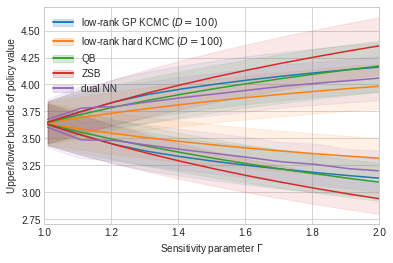

In [101]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_method)}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "low-rank hard KCMC ($D=100$)", "QB", "ZSB", "dual NN"]

for method_name in grid_method:
    upper = np.array([values_mean.loc[(method_name, Gamma)]["upper_bound"] for Gamma in grid_Gamma])
    lower = np.array([values_mean.loc[(method_name, Gamma)]["lower_bound"] for Gamma in grid_Gamma])
    dupper = np.array([values_std.loc[(method_name, Gamma)]["upper_bound"] for Gamma in grid_Gamma])
    dlower = np.array([values_std.loc[(method_name, Gamma)]["lower_bound"] for Gamma in grid_Gamma])
    c = colors[method_name]
    upper_line = plt.plot(grid_Gamma, upper, c=c)[0]
    lower_line = plt.plot(grid_Gamma, lower, c=c)[0]
    upper_band = plt.fill_between(grid_Gamma, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_Gamma, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.savefig("logs/policy_evaluation_synthetic_binary_changing_Gamma_nn.pdf")

Notes on data types:

- Only use torch tensor for `Y` and `r`
- For other data, use numpy array